# Elaborate statistics features for Silvereye

## Dependencies imports


In [1]:
import xarray as xr
import os
import sys
import pandas as pd
from functools import wraps
import numpy as np

import matplotlib.pyplot as plt

In [100]:
from datetime import date
from dateutil.relativedelta import relativedelta # $ pip install python-dateutil

In [2]:
import seaborn as sns  # noqa, pandas aware plotting library

In [3]:
if ('SP_SRC' in os.environ):
    root_src_dir = os.environ['SP_SRC']
elif sys.platform == 'win32':
    root_src_dir = r'C:\src\csiro\stash\silverpieces'
else:
    root_src_dir = '/home/per202/src/csiro/stash/silverpieces'

pkg_src_dir = root_src_dir
sys.path.append(pkg_src_dir)

In [4]:
if ('SP_DATA' in os.environ):
    root_data_dir = os.environ['SP_DATA']
elif sys.platform == 'win32':
    root_data_dir = r'C:\data\silverpieces'
else:
    root_data_dir = '/home/per202/data/silverpieces'


In [91]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# the default cmap_sequential for xarray is viridis. 'RdBu' is divergent, but works better for wetness concepts
xr.set_options(cmap_sequential='RdBu')

In [131]:
# Can get tassie_silo_rain.nc data from https://cloudstor.aarnet.edu.au/plus/s/nj2RevvD1EUD77n
fn = os.path.join(root_data_dir, 'tassie_silo_rain.nc')

In [9]:
tassie = xr.open_dataset(os.path.join(root_data_dir, 'tassie_silo_rain.nc'))

In [10]:
tassie

<xarray.Dataset>
Dimensions:     (lat: 79, lon: 99, time: 4383)
Coordinates:
  * lon         (lon) float64 144.1 144.1 144.2 144.2 ... 148.8 148.9 148.9
  * lat         (lat) float64 -43.95 -43.9 -43.85 -43.8 ... -40.15 -40.1 -40.05
  * time        (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2018-12-31
Data variables:
    daily_rain  (time, lat, lon) float32 ...

In [11]:
dr = tassie.daily_rain

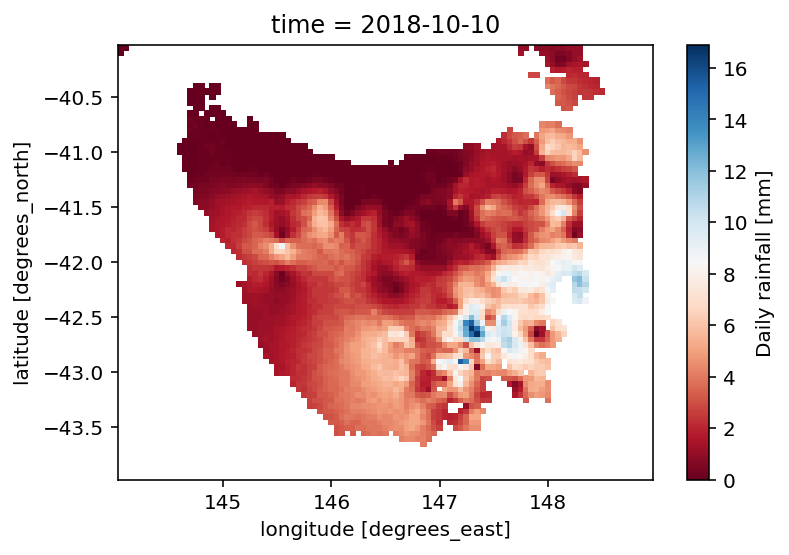

In [132]:
dr.isel(time=4300).plot()

## Use cases

### 3 year period statistic compared to all 3 years periods in the historical record

We want to be able to compare a grid of statistics for a period compared to all periods of similar lengths.
The start and end of the period should be as arbitrary as possible. The sliding window could however be limited or fixed to a year: it is probably moot to compare windows with shifted seasonality. 

#### How does the cumulated rainfall 2016-2018 over TAS compare with all 3 year periods over the record?


In [13]:
start_time = pd.to_datetime('2016-01-01')
end_time = pd.to_datetime('2018-12-31')

In [21]:
dr.isel(time = 1)

<xarray.DataArray 'daily_rain' (lat: 79, lon: 99)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [1.8, nan, nan, ..., nan, nan, nan],
       [2.3, 1.9, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 144.1 144.1 144.2 144.2 ... 148.8 148.8 148.9 148.9
  * lat      (lat) float64 -43.95 -43.9 -43.85 -43.8 ... -40.15 -40.1 -40.05
    time     datetime64[ns] 2007-01-02
Attributes:
    long_name:    Daily rainfall
    units:        mm
    _ChunkSizes:  [1000   40   40]

In [93]:
cum_rain = dr.loc[dict(time=slice(start_time, end_time))].sum(dim='time',skipna=False)

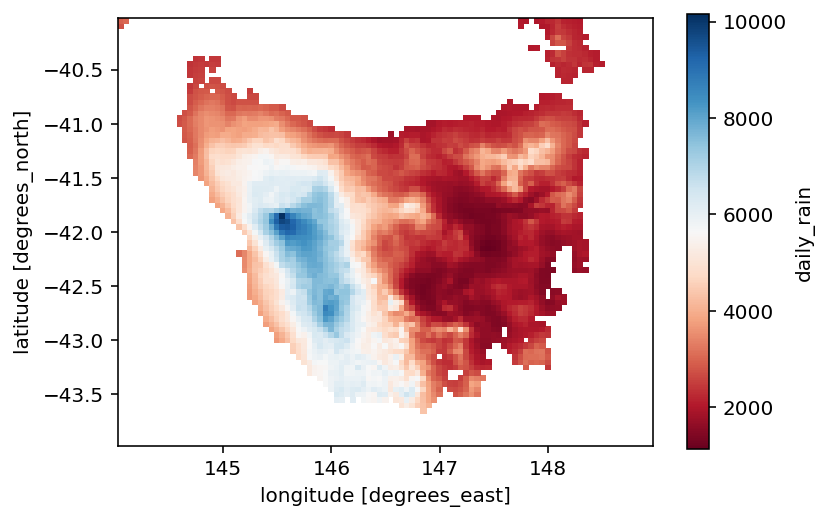

In [96]:
plt.axis('scaled')
cum_rain.plot()

In [98]:
TIME_DIMNAME = 'time'

In [99]:
start_time = pd.to_datetime('2007-01-01')
end_time = pd.to_datetime('2009-12-31')

In [101]:
print(start_time + relativedelta(years=+1))

2008-01-01 00:00:00


In [102]:
cumulated = [dr.loc[dict(time=slice(start_time + relativedelta(years=year), end_time+ relativedelta(years=year)))].sum(dim='time',skipna=False) for year in range(10)]

In [103]:
cumulated[0]

<xarray.DataArray 'daily_rain' (lat: 79, lon: 99)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [2760.7996,       nan,       nan, ...,       nan,       nan,       nan],
       [2929.2988, 3064.8992,       nan, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 144.1 144.1 144.2 144.2 ... 148.8 148.8 148.9 148.9
  * lat      (lat) float64 -43.95 -43.9 -43.85 -43.8 ... -40.15 -40.1 -40.05

In [104]:
three_years_rains = xr.concat(cumulated, dim=TIME_DIMNAME)
three_years_rains.name = 'cum_rain_3yr'

In [105]:
three_years_rains['time']= [end_time + relativedelta(years=year) for year in range(len(cumulated))]
three_years_rains['time']

<xarray.DataArray 'time' (time: 10)>
array(['2009-12-31T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-12-31T00:00:00.000000000', '2012-12-31T00:00:00.000000000',
       '2013-12-31T00:00:00.000000000', '2014-12-31T00:00:00.000000000',
       '2015-12-31T00:00:00.000000000', '2016-12-31T00:00:00.000000000',
       '2017-12-31T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-12-31 2010-12-31 ... 2018-12-31

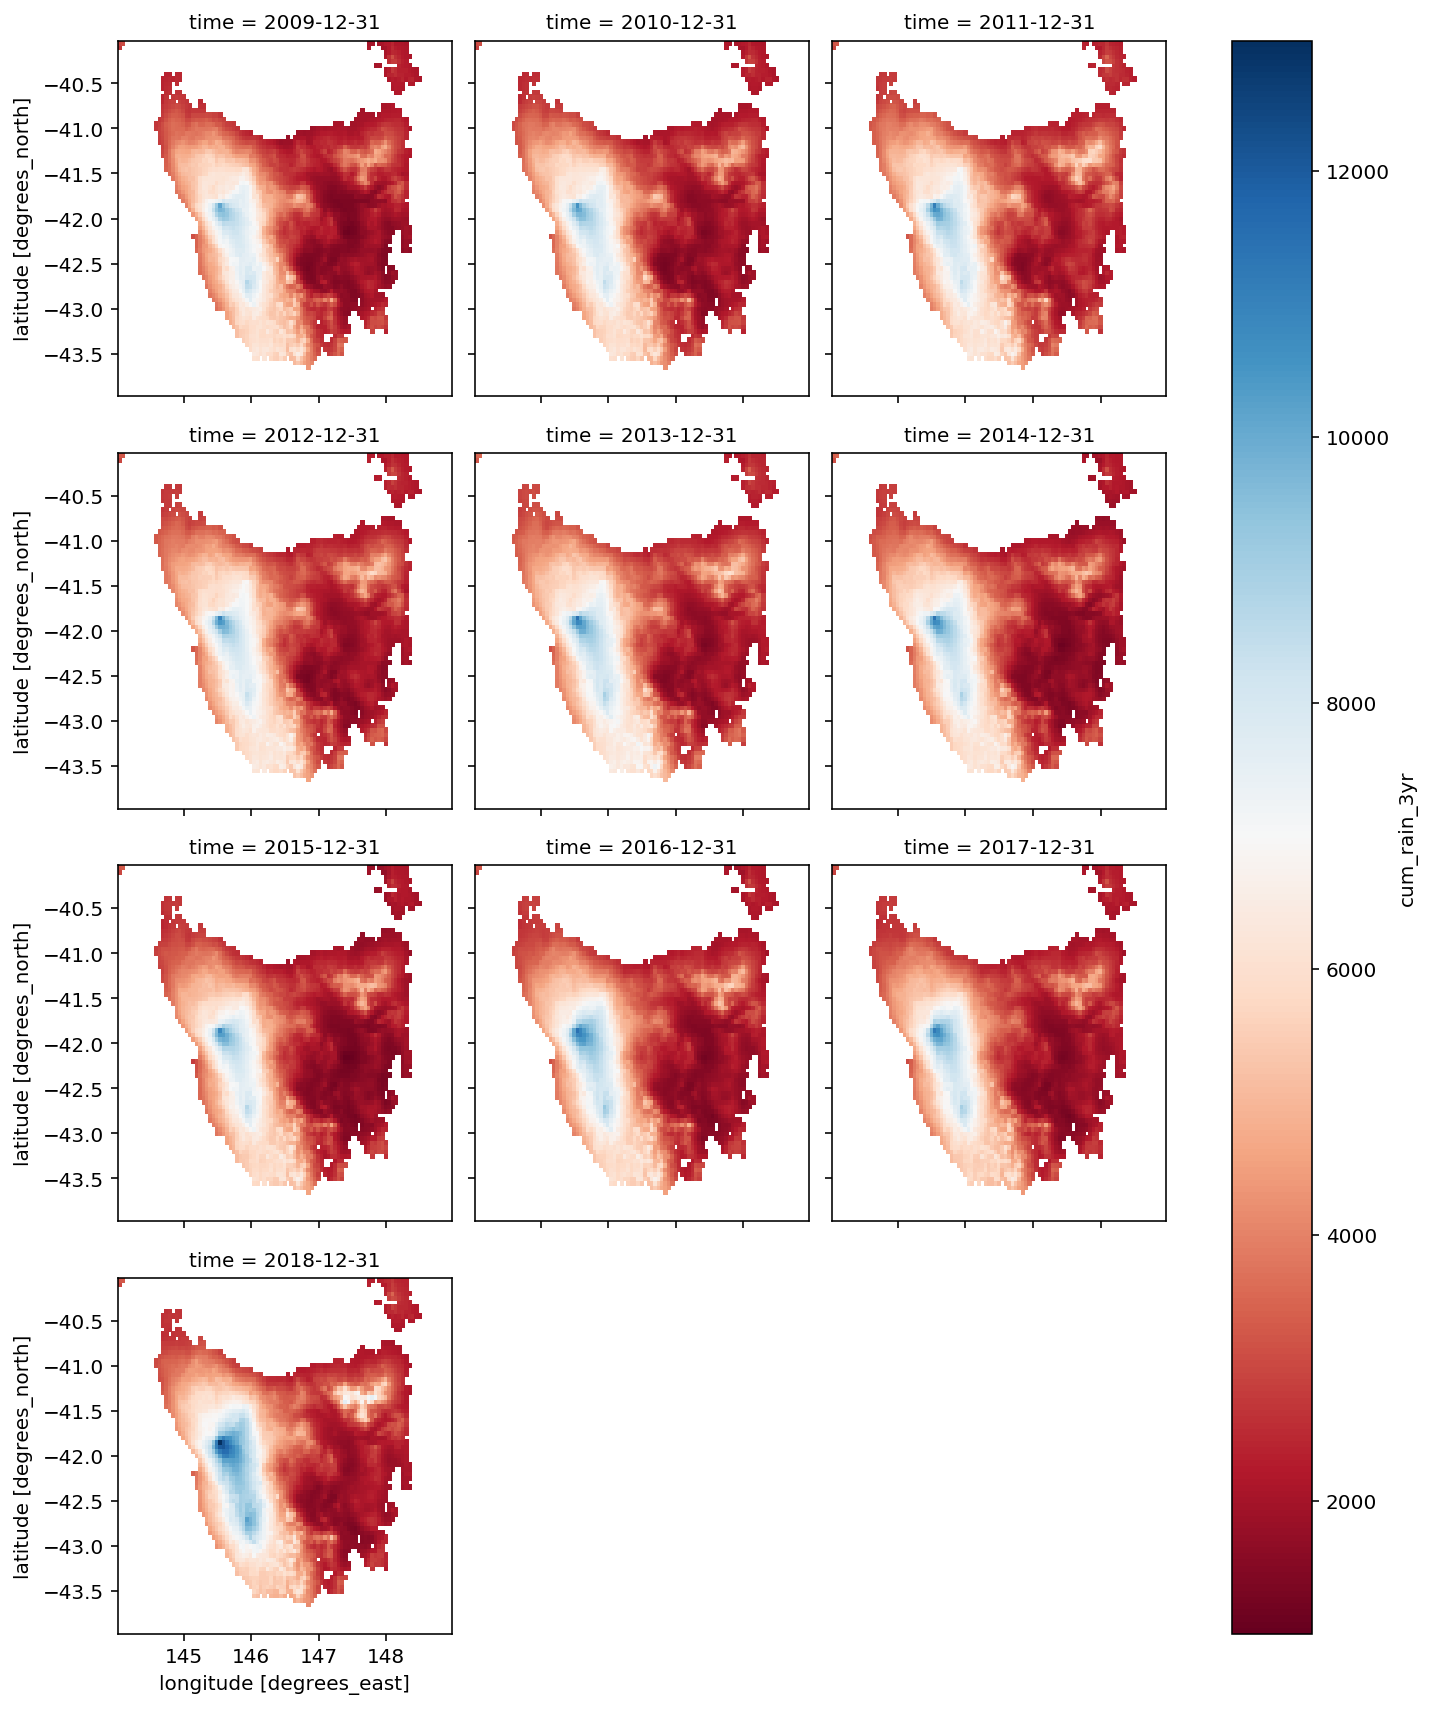

In [107]:
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
g_simple = three_years_rains.plot(x='lon', y='lat', col='time', col_wrap=3)

In [108]:
q = np.array([.1, .5, .9])

In [112]:
x = np.quantile(three_years_rains, q=q, axis=0, out=None, overwrite_input=False, interpolation='linear', keepdims=False)
x.shape

(3, 79, 99)

In [120]:
three_years_rains.coords, three_years_rains.dims

(Coordinates:
   * lon      (lon) float64 144.1 144.1 144.2 144.2 ... 148.8 148.8 148.9 148.9
   * lat      (lat) float64 -43.95 -43.9 -43.85 -43.8 ... -40.15 -40.1 -40.05
   * time     (time) datetime64[ns] 2009-12-31 2010-12-31 ... 2018-12-31,
 ('time', 'lat', 'lon'))

In [126]:
y = xr.DataArray(x, 
                coords=[
                    q, 
                    three_years_rains.coords['lat'],
                    three_years_rains.coords['lon']
                ],
                dims=['quantile', 'lat', 'lon'],
                name='quantiles (mm)')

In [127]:
y

<xarray.DataArray 'quantiles (mm)' (quantile: 3, lat: 79, lon: 99)>
array([[[        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan],
        ...,
        [2828.117188,         nan, ...,         nan,         nan],
        [3030.547949, 3118.361938, ...,         nan,         nan]],

       [[        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan],
        ...,
        [2986.400269,         nan, ...,         nan,         nan],
        [3242.249756, 3274.650757, ...,         nan,         nan]],

       [[        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan],
        ...,
        [3150.589087,         nan, ...,         nan,         nan],
        [3430.982227, 3497.130225, ...,         nan,         nan]]])
Coordinates:
  * quantile  (quantile) float64 0.1 0.5 0.9
  * lat       (lat) float

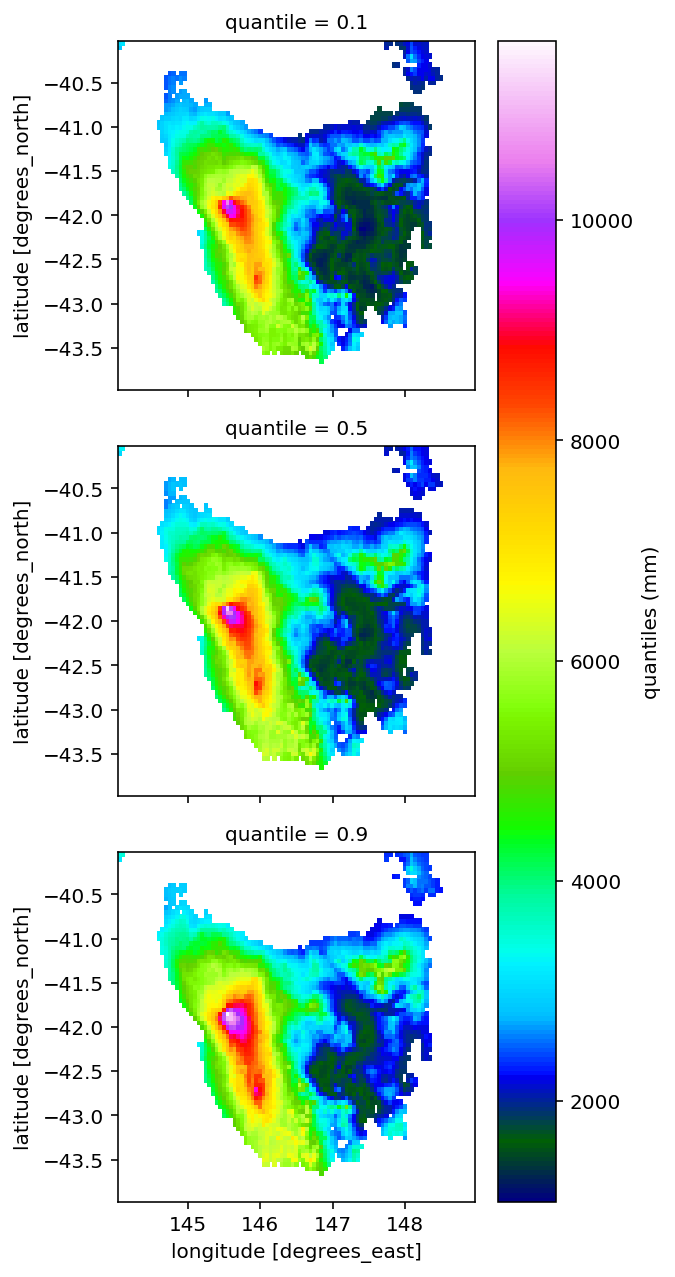

In [130]:
y.plot(x='lon', y='lat', col='quantile', col_wrap=1, cmap='gist_ncar')
